# Исследование продаж интернет-магазина «Стримчик»

Цель исследование продаж интернет-магазина «Стримчик» продающих игры по всему миру.

Данные возьмем из открытых источников:<br>
* О продажах игр;
* оценки пользователей и экспертов;
* жанры;
* платформы.

Выявим определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.<br>

Таким образом, исследование пройдёт в пять этапов:
* Загрузка данных и изучение общей информации
* Подготовка датафрейма games
* Исследовательский анализ данных
    * Анализ количества игр выпущенных в разные годы
    * Анализ изменения продаж по платформам
    * Выборка данных за актуальный период
    * Определение потенциально прибыльных платформ
    * Изучение влияния на продажи внутри одной популярной платформы отзывы пользователей и критиков 
    * Распределение игр по жанрам
* Составьте портрет пользователя каждого региона¶
    * Самые популярные платформы¶
    * Самые популярные жанры
    * Влияние рейтинга ESRB на продажи в отдельных регионах
* Проверка гипотез
    * Проверка гипотезы средние пользовательские рейтинги платформ Xbox One и PC одинаковые
    * Проверка гипотезы средние пользовательские рейтинги жанров Action и Sports разные
* Вывод

## Загрузка данных и изучение общей информации

### Загрузка библиотек и данных

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

games = pd.read_csv('games.csv')

### Осмотр данных

In [3]:
display(games.head(2))
games.info()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14883 entries, 0 to 14882
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             14881 non-null  object 
 1   Platform         14882 non-null  object 
 2   Year_of_Release  14649 non-null  float64
 3   Genre            14880 non-null  object 
 4   NA_sales         14882 non-null  float64
 5   EU_sales         14882 non-null  float64
 6   JP_sales         14882 non-null  float64
 7   Other_sales      14882 non-null  float64
 8   Critic_Score     7645 non-null   float64
 9   User_Score       9286 non-null   object 
 10  Rating           9238 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.2+ MB


### Вывод

Загружены данные для проведения анализа и необходимые библиотеки

## Подготовка датафрейма games

### Скорректировать названия на lower_case

In [4]:
for column in games.columns:
    games.rename(columns={column: column.lower()}, inplace=True)
    
games.head(2)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN


### Корректировка значений

#### Корректировка значений в колонке name

In [5]:
games[games['name'].isna() != False]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Удаляем эти строки, так как в них слишком мало данных, а на ход анализа это не повлияет

In [6]:
games = games[games['name'].isna() == False]

#### Корректировка значений в колонке year_of_release

Заполняем отсутствующие значения колонки year_of_release значениями этой же колонки найденной по колонке name и проверяем сколько осталось не заполнено

In [7]:
missed_year_of_release_names = games[games['year_of_release'].isna()]['name'].unique()
for name in missed_year_of_release_names:
    games.loc[games['name'] == name, 'year_of_release'] = games[games['name'] == name]['year_of_release'].max()

print('Количество оставшихся не заполненных значений:', games['year_of_release'].isna().sum())

Количество оставшихся не заполненных значений: 129


Для проведения анализа данные колонки year_of_release критические, то есть строки с отсутствующими значениями мы анализировать не можем. Мы их удаляем, подразумевая то, что таких строк очень мало и на ход анализа удаление этого количества не повлияет

In [8]:
games = games[games['year_of_release'].isnull() == False]

Переводим колонку year_of_release из float64 в int64 для удобство обработки

In [9]:
games['year_of_release'] = games['year_of_release'].astype(int)

#### Корректировка значений в колонке genre

In [10]:
print('Количество не заполненных значений:', games['genre'].isna().sum())

Количество не заполненных значений: 0


Отсутствующих значений в колонке нет, проверка на аномальные значения

In [11]:
games['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

Аномальных значений нет

#### Корректировка значений в колонке platform

In [12]:
print('Количество не заполненных значений:', games['platform'].isna().sum())

Количество не заполненных значений: 0


Отсутствующих значений в колонке нет, проверка на аномальные значения

In [13]:
games['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

Аномальных значений нет

#### Корректировка значений в колонках na_sales, eu_sales, jp_sales, other_sales + добавление колонки total_sales

In [14]:
print('Количество не заполненных значений na_sales:', games['na_sales'].isna().sum())
print('Количество не заполненных значений eu_sales:', games['eu_sales'].isna().sum())
print('Количество не заполненных значений jp_sales:', games['jp_sales'].isna().sum())
print('Количество не заполненных значений other_sales:', games['other_sales'].isna().sum())

Количество не заполненных значений na_sales: 0
Количество не заполненных значений eu_sales: 0
Количество не заполненных значений jp_sales: 0
Количество не заполненных значений other_sales: 0


Отсутствующих значений нет, проверим на адекватность

In [15]:
print(games['na_sales'].describe())
print(games['eu_sales'].describe())
print(games['jp_sales'].describe())
print(games['other_sales'].describe())

count    14752.000000
mean         0.295913
std          0.859845
min          0.000000
25%          0.020000
50%          0.100000
75%          0.270000
max         41.360000
Name: na_sales, dtype: float64
count    14752.000000
mean         0.163244
std          0.532952
min          0.000000
25%          0.000000
50%          0.030000
75%          0.130000
max         28.960000
Name: eu_sales, dtype: float64
count    14752.000000
mean         0.086680
std          0.327532
min          0.000000
25%          0.000000
50%          0.000000
75%          0.050000
max         10.220000
Name: jp_sales, dtype: float64
count    14752.000000
mean         0.053414
std          0.197889
min          0.000000
25%          0.000000
50%          0.010000
75%          0.040000
max         10.570000
Name: other_sales, dtype: float64


Значения адекватны, в северной Америке значений больше всего, в Европе меньше далее все остальные.<br>
Добавим колонку total_sales

In [16]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

#### Корректировка значений в колонках critic_score, user_score, rating

In [17]:
print('Количество не заполненных значений critic_score:', games['critic_score'].isna().sum())
print('Количество не заполненных значений user_score:', games['user_score'].isna().sum())
print('Количество не заполненных значений rating:', games['rating'].isna().sum())

Количество не заполненных значений critic_score: 7165
Количество не заполненных значений user_score: 5541
Количество не заполненных значений rating: 5589


Количество не заполненых колонок очень велико, однако для их замены нет логичного метода, оставляем как есть

Проверка на аномальные значения колонки critic_score

In [18]:
games[games['critic_score'].notna()]['critic_score'].unique()

array([76., 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88., 83.,
       94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92., 71.,
       72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64., 75.,
       60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47., 65.,
       54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51., 40.,
       46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23., 24.,
       21., 17., 13.])

Аномальных значений нет, изменяем тип значений на float64

In [19]:
games['critic_score'] = games['critic_score'].astype(float)

Проверка на аномальные значения колонки user_score

In [20]:
games[games['user_score'].notna()]['user_score'].unique()

array(['8', '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4', '8.2',
       '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2', '8.9',
       '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3', '7.6',
       '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8', '6.1',
       '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6', '3.7',
       '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3', '2.7',
       '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0', '1.6',
       '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2', '2.3',
       '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'], dtype=object)

Есть значение tbd, что скорее всего обозначает "to be determinated", то есть неизвестно, поэтому заменяем на nan и меняем тип колонки на float64

In [21]:
games.loc[games['user_score'] == 'tbd', 'user_score'] = np.nan
games['user_score'] = games['user_score'].astype(float)

Проверка на аномальные значения колонки rating

In [22]:
games[games['rating'].notna()]['rating'].unique()

array(['E', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Посмотрим расшифровку рейтингов:
* E - everyone
* M - older 17 years
* T - older 13 years
* E10+ - everyone 10+
* K-A - everyone
* AO - adults only
* C - child hood

Значение RP обозначет RatingPending, то есть ожидание рейтинга - значением не известно,<br>
K-A раннее обозначение рейтинга для всех, заменяем K-A на Е


In [23]:
games['rating'].value_counts().to_frame()

,rating
E,3654
T,2715
M,1460
E10+,1322
EC,8
K-A,2
AO,1
RP,1


In [24]:
games.loc[games['rating'].isna(), 'rating'] = 'NR'
games.loc[games['rating'] == 'RP', 'rating'] = 'NR'
games.loc[games['rating'] == 'K-A', 'rating'] = 'E'

#### Вывод

* Колонка name;
    * Удалены две строки с пустыми значениями;
* Колонка year_of_release;
    * Заполнены отсутствующие значения колонки значениями этой же колонки, найденной по колонке name;
    * Отсутствие данных колонки критично, то есть строки с отсутствующими значениями мы анализировать не можем. Мы их удаляем, подразумевая то, что таких строк очень мало и на ход анализа удаление этого количества не повлияет;
    * Переводим колонку из float64 в int64 для удобство обработки;
* Добавление колонки total_sales на основе, суммы колонок na_sales, eu_sales, jp_sales, other_sales;
* Колонки critic_score, user_score;
    * Количество не заполненых колонок очень велико, однако для их замены нет корректного метода, оставляем как есть;
    * Переводим колонку critic_score и user_score из float64 в int64 для удобство обработки;
    * Значение tbd обозначает "to be determinated", то есть неизвестно, заменяем на nan;
* Колонка rating;
    * Все пустые значения заменены на 'NR', для выделения области игр без рейтинга;
    * Заменено значение RP на 'NR', так как RP это обозначение ожидание рейтинга, а не рейтинг;
    * Заменено значение K-A на E, так как K-A ранее использовалось как Е.

## Исследовательский анализ данных

### Анализ количества игр выпущенных в разные годы

Создание сводной таблицы для расчета количества выпущенных игр

In [25]:
game_year = pd.pivot_table(games, values='name', index=['year_of_release'], aggfunc='count').reset_index().sort_values(by='year_of_release')
game_year.columns = ['year_of_release', 'count_of_games']
game_year.head(2)

,year_of_release,count_of_games
0,1980,9
1,1981,46


Строим график

/var/folders/s_/k78btxl90cl6blfr_9c4l_200000gn/T/ipykernel_14071/4044301812.py:3: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='both')


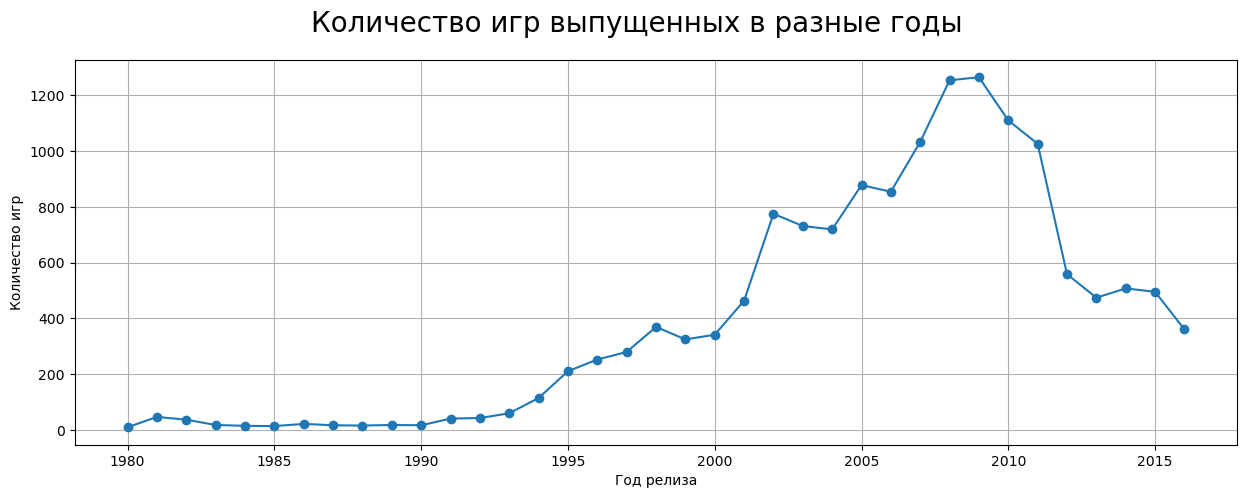

In [26]:
plt.figure(figsize=(15,5))
plt.plot(game_year['year_of_release'], game_year['count_of_games'], marker='o') 
plt.grid(b=True, which='both')
plt.suptitle('Количество игр выпущенных в разные годы', fontsize=20)
plt.xlabel('Год релиза', fontsize=10)
plt.ylabel('Количество игр', fontsize=10)
plt.show()

Вывод:<br>
Из графика видно, что количество выпускаемых игр до 1990 остается приблизительно на одном и том же уровне, что связано очевидно со слабой распространенностью компьютеров и приставок (кроме бума в 1981, обоснованным появлением первых устройств).<br>
Далее видим сильное возрастания количества выпускаемых игр в год, что в первую очередь связано с тем, что устройства для игр стали становиться сильно доступнее для массового потребления.<br>
С 2000 года по 2010 год мы видим стремительное увеличение выпускаемых игр в год, что обосновано появлением интернета и устройств позволяющих играть почти в каждом доме, а так же в связи с комерциализацией этой отрасли. В это время игры приносили очень большие доходы, в связи с чем их разрабатывалось очень много.<br>
С 2010 года мы видим сворачивание выпуска игр, так как в предыдущие годы появилось слишком много компаний и частных разработчиков выпускающих большое количество не качественных игр ради заработка, инвесторы начали переходить от количества проектов к качеству, а так же из за пресыщения рынка не качественными продуктами.


### Анализ изменения продаж по платформам

Выбор топ 10 платформ для анализа

In [27]:
top10_platform2  = pd.pivot_table(games, values='total_sales', index=['platform'], aggfunc='sum').reset_index().sort_values(by=['total_sales'], ascending=False).head(10).reset_index()[['platform', 'total_sales']]
top10_platform2

,platform,total_sales
0,PS2,1243.53
1,X360,965.27
2,PS3,933.68
3,Wii,901.72
4,DS,799.90
5,PS,726.74
6,PS4,313.39
7,GBA,312.47
8,PSP,289.55
9,3DS,257.72


Построение сводной таблицы по суммарным продажам по каждой платформе в каждом году (отсюда мы будем брать данные для графика)

In [28]:
df_platform_graph = pd.pivot_table(games, values='total_sales', index=['platform', 'year_of_release'], aggfunc='sum').reset_index()
df_platform_graph.head(2)

,platform,year_of_release,total_sales
0,2600,1980,11.38
1,2600,1981,35.68


Построение графика по топ 10 платформам

/var/folders/s_/k78btxl90cl6blfr_9c4l_200000gn/T/ipykernel_14071/1408755620.py:6: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='both')


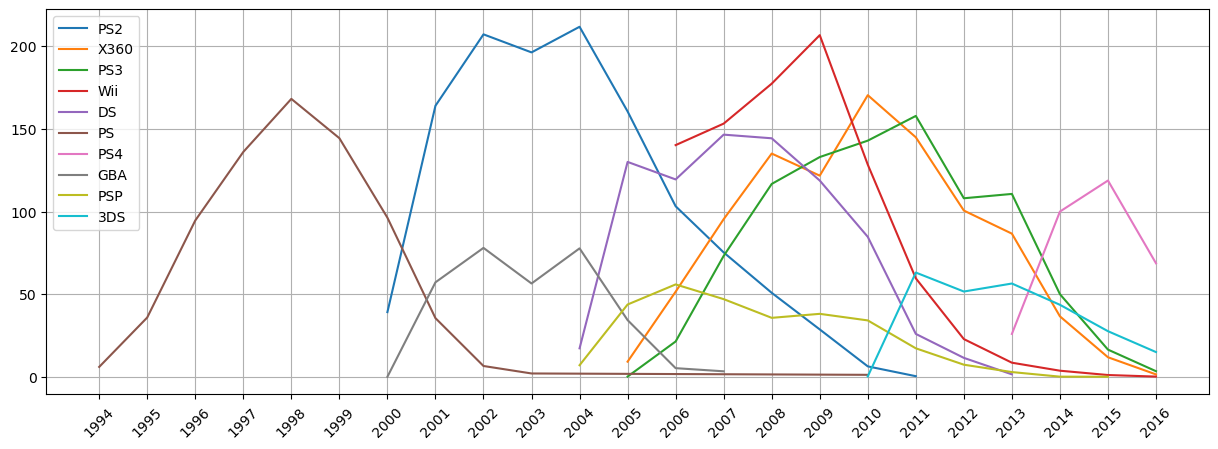

In [29]:
plt.figure(figsize=(15,5))
for platform in top10_platform2['platform'].unique():
    plt.plot(df_platform_graph.query('platform == @platform and year_of_release > 1993')['year_of_release'],df_platform_graph.query('platform == @platform and year_of_release > 1993')['total_sales'], label=platform)
    plt.legend()
plt.xticks(df_platform_graph[df_platform_graph['year_of_release'] > 1993]['year_of_release'].unique(), rotation = 45)
plt.grid(b=True, which='both')
plt.show()


По графику видим, что в среднем платформы набирают популярность около пяти лет, затем три четыре года популярность падает<br>
Расчитаем среднюю величину срока жизни платформы

Создадим датафрейм с годом первого выпуска игры на платформы и последнего года выпуска игры на платформе

In [30]:
min_max = pd.pivot_table(df_platform_graph, values='year_of_release', index=['platform'], aggfunc=['min','max']).reset_index()
min_max.columns = ['platform', 'min_year_of_release', 'max_year_of_release']
min_max['life_years'] = min_max['max_year_of_release'] - min_max['min_year_of_release']
min_max.head(2)

,platform,min_year_of_release,max_year_of_release,life_years
0,2600,1980,2002,22
1,3DO,1995,1995,0


In [31]:
print('Медианное время жизни платформы:', int(min_max['life_years'].median()))

Медианное время жизни платформы: 8


Вывод:<br>
* В среднем платформы набирают популярность около пяти лет, затем три четыре года популярность падает
* Медианное время жизни платформы: 8 лет

### Выборка данных за актуальный период

Актуальный период это перид с 2012 года по 2016 год, так как с 2012 года рынок перешел к новой логике потребления о чем мной было описано в выводе пункта 3.1.

In [32]:
actual_period = games[games['year_of_release'].between(2012, 2016)]
actual_period.head(2)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27


Вывод: Актуальный период это перид с 2012 года по 2016 год, так как с 2012 года рынок перешел к новой логике потребления о чем мной было описано в выводе пункта 3.1.

### Определение потенциально прибыльных платформ

Построим графики для определения динамики продаж и лидеров по продажам в актуальном периоде

In [33]:
platform_sales_dynamic = pd.pivot_table(actual_period, values='total_sales', index=['platform', 'year_of_release'], aggfunc='sum').reset_index()
platform_sales_dynamic.columns = ['platform', 'year_of_release', 'total_sales']

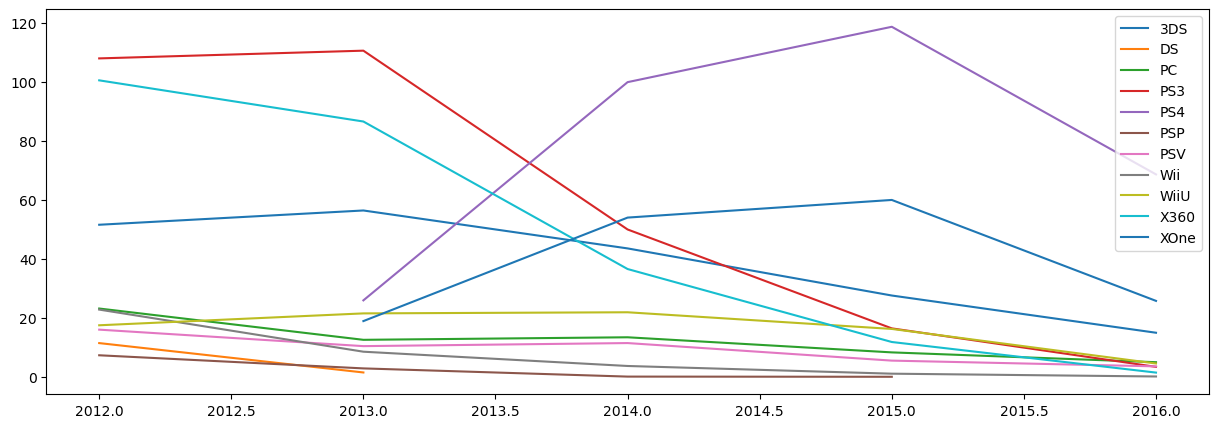

In [34]:
plt.figure(figsize=(15,5))
for platform in platform_sales_dynamic['platform'].unique():
    plt.plot(platform_sales_dynamic[platform_sales_dynamic['platform'] == platform]['year_of_release'],platform_sales_dynamic[platform_sales_dynamic['platform'] == platform]['total_sales'], label=platform)
    plt.legend()
plt.show()

Вывод:<br>
Так как сейчас декабрь 2016 года рассматриваем результаты 2015 года:
* Лидируют по продажам:
    * PS4
    * XOne
    * 3DS
* Продажи растут:
    * PS4
    * XOne
* Продажи падают:
    * 3DS

### График «ящик с усами» по глобальным продажам игр в разбивке по платформам

Для построения графика создадим датафрейм с топ 3 потенциально прибыльными платформами выбранными в пункте выше

In [35]:
best_platform = ['PS4', 'XOne', '3DS']
box_plot_df = actual_period.query('platform in @best_platform')

<AxesSubplot: xlabel='platform', ylabel='total_sales'>

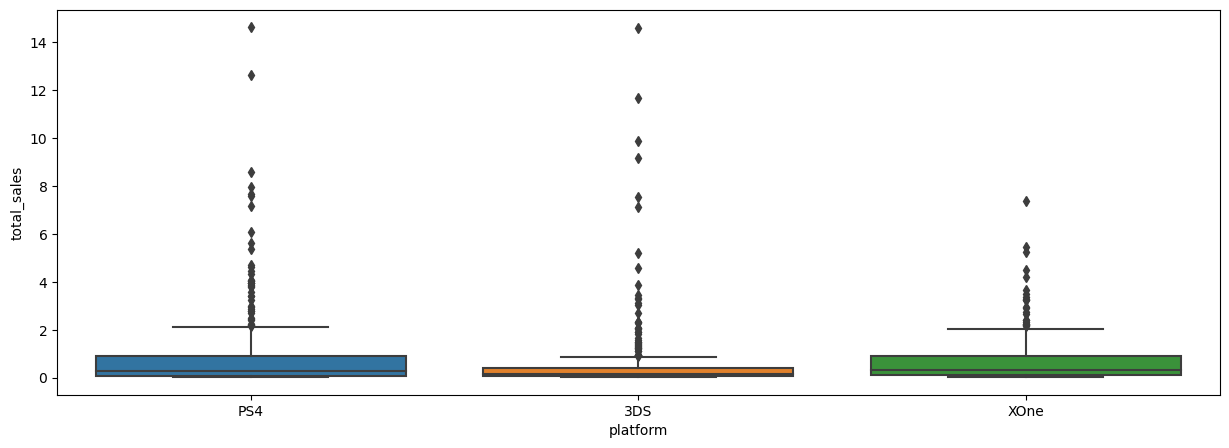

In [36]:
plt.figure(figsize=(15,5))
sns.boxplot(data=box_plot_df, x='platform', y='total_sales')

<AxesSubplot: xlabel='platform', ylabel='total_sales'>

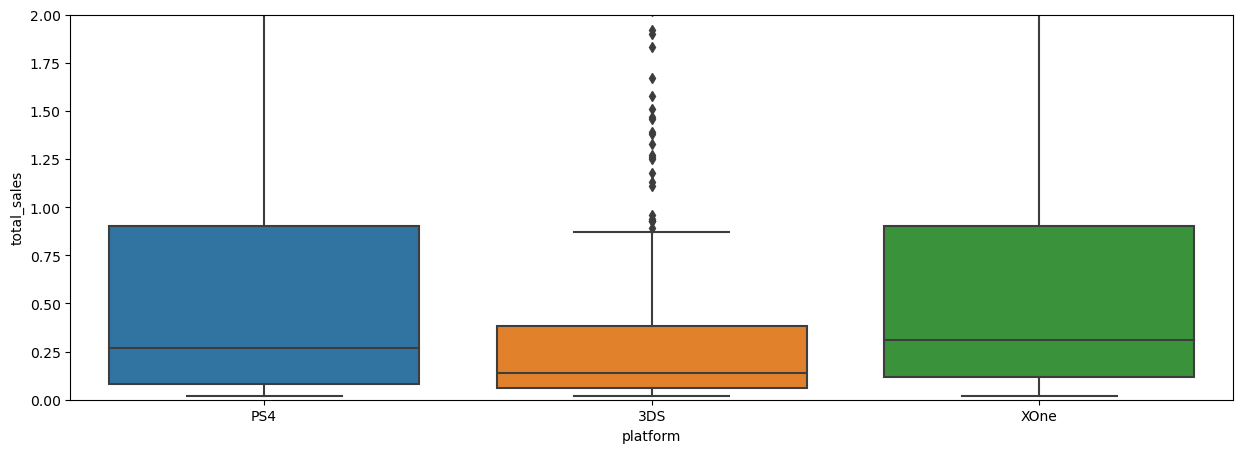

In [37]:
plt.figure(figsize=(15,5))
plt.ylim([0,2])
sns.boxplot(data=box_plot_df, x='platform', y='total_sales')

Вывод:<br>
* Показатели продаж PS4 и XOne очень похожи, что в целом логично так как это конкурирующие платформы;
* Все остальные платформы имеют показатели продаж сильно ниже;


### Изучение влияния на продажи внутри одной популярной платформы отзывы пользователей и критиков 

Создание датафрейма с данными платформы PS4

In [38]:
ps4_games = actual_period[actual_period['platform'] == 'PS4']
ps4_games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NR,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NR,7.98
92,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66


Построение диаграммы рассеяния и расчет корреляции между отзывами пользователей и продажами

Корреляция между отзывами пользователей и продажами: -0.05433721976639329


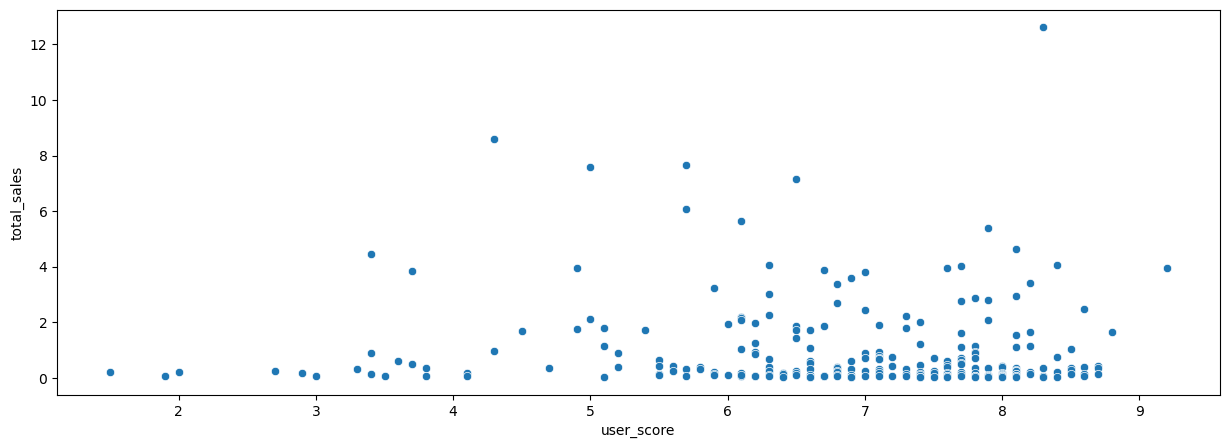

In [39]:
plt.figure(figsize=(15,5))
sns.scatterplot(data=ps4_games, x="user_score", y="total_sales")

print('Корреляция между отзывами пользователей и продажами:', ps4_games['user_score'].corr(ps4_games['total_sales']))

Построение диаграммы рассеяния и расчет корреляции между отзывами критиков и продажами

Корреляция между отзывами критиков и продажами: 0.39084429649629093


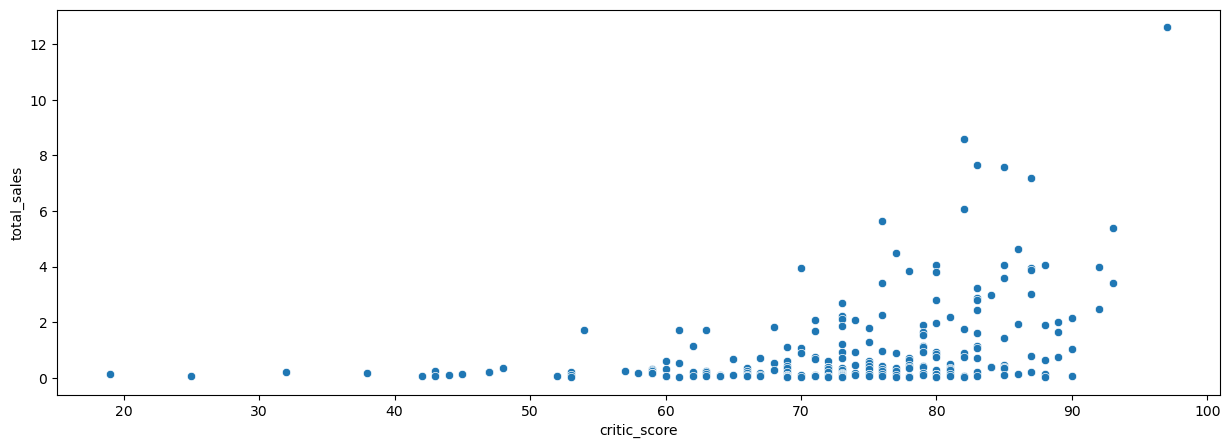

In [40]:
plt.figure(figsize=(15,5))
sns.scatterplot(data=ps4_games, x="critic_score", y="total_sales")

print('Корреляция между отзывами критиков и продажами:', ps4_games['critic_score'].corr(ps4_games['total_sales']))

Вывод:
* Корреляция между отзывами пользователей и продажами: -0.054
    * Однако согласно графику мы все видим, что зависимость на самом деле присутствует (это связано с выбросами, большие продажи при плохих оценках), чем больше оценка пользователей, тем больше вероятность на коммерческий успех;
* Корреляция между отзывами критиков и продажами: 0.391
    * Данные говорят о том, что чем больше оценка критиков, тем больше вероятность на коммерческий успех, но все же довольно таки много случаев, когда при высокой оценке продажи не высокие.

Корреляция между отзывами пользователей и продажами: -0.061244926753852826
Корреляция между отзывами критиков и продажами: 0.40014769239817705


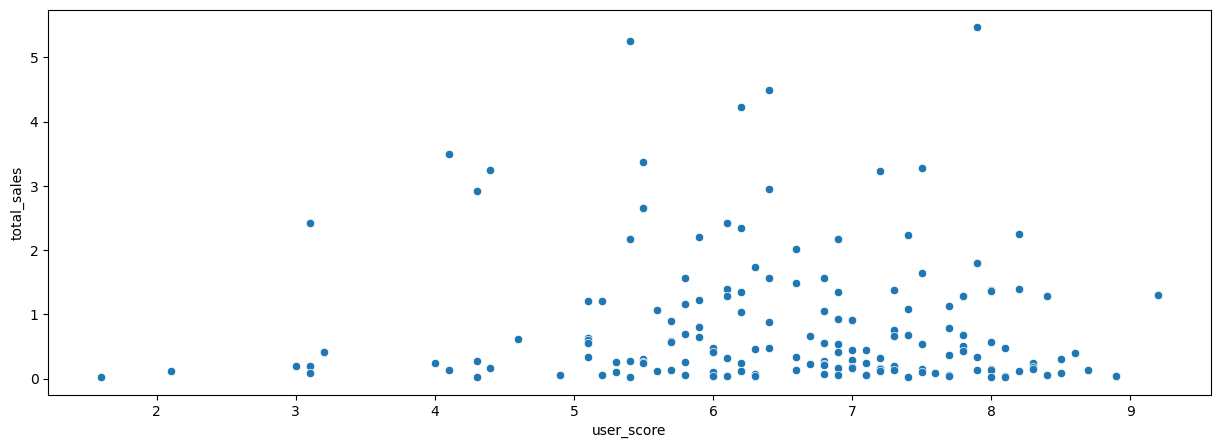

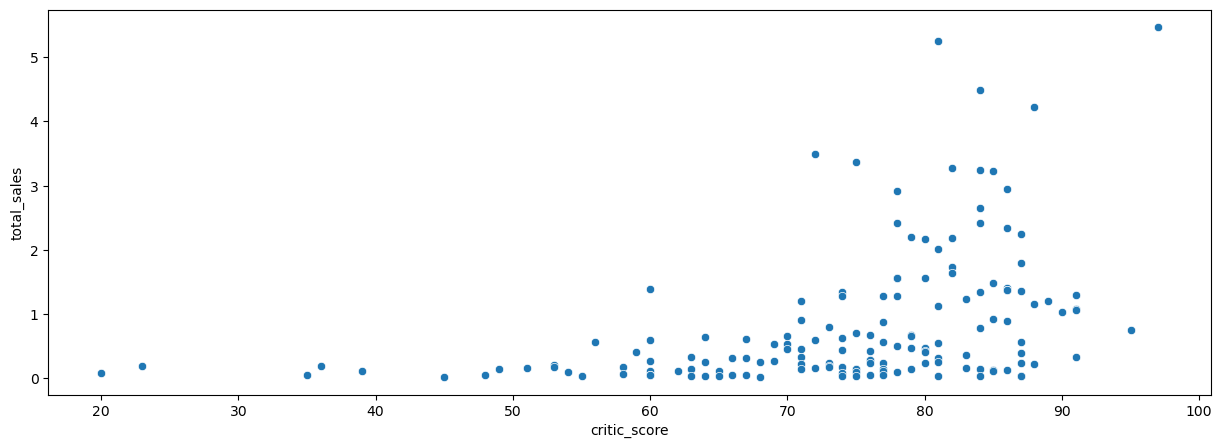

In [41]:
XOne_games = actual_period[actual_period['platform'] == 'XOne']

plt.figure(figsize=(15,5))
sns.scatterplot(data=XOne_games, x="user_score", y="total_sales")

print('Корреляция между отзывами пользователей и продажами:', XOne_games['user_score'].corr(XOne_games['total_sales']))

plt.figure(figsize=(15,5))
sns.scatterplot(data=XOne_games, x="critic_score", y="total_sales")

print('Корреляция между отзывами критиков и продажами:', XOne_games['critic_score'].corr(XOne_games['total_sales']))

Корреляция между отзывами пользователей и продажами: 0.20598132967167498
Корреляция между отзывами критиков и продажами: 0.33558429044021393


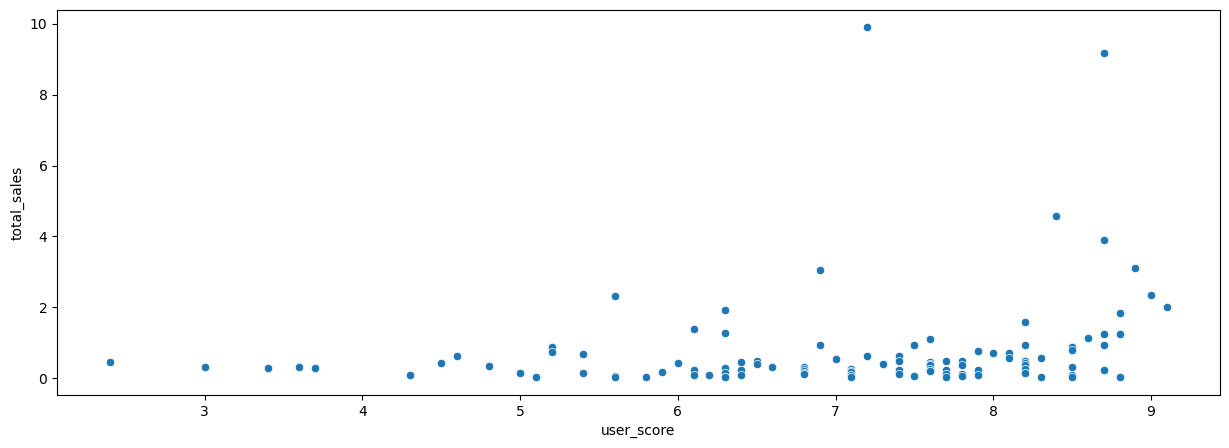

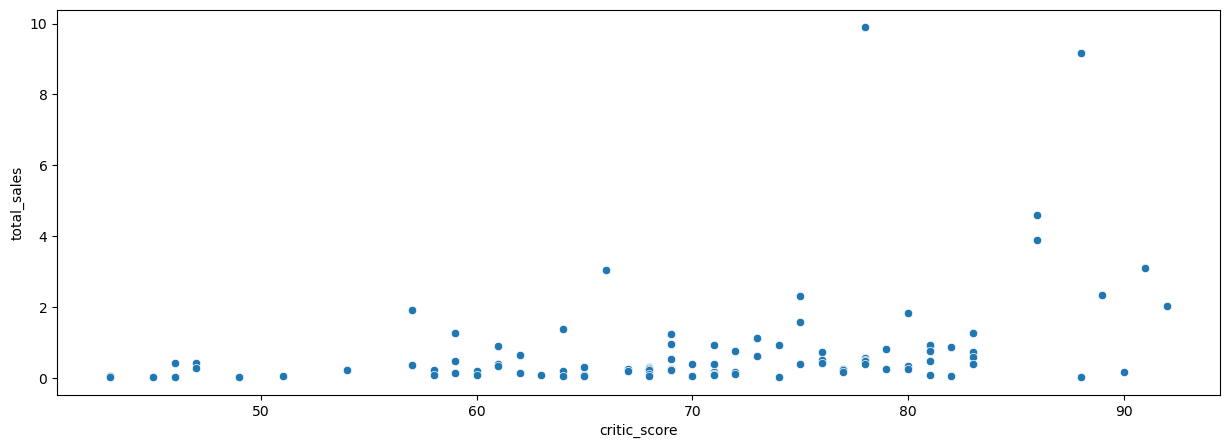

In [42]:
DS_games = actual_period[actual_period['platform'] ==  '3DS']

plt.figure(figsize=(15,5))
sns.scatterplot(data=DS_games, x="user_score", y="total_sales")

print('Корреляция между отзывами пользователей и продажами:', DS_games['user_score'].corr(DS_games['total_sales']))

plt.figure(figsize=(15,5))
sns.scatterplot(data=DS_games, x="critic_score", y="total_sales")

print('Корреляция между отзывами критиков и продажами:', DS_games['critic_score'].corr(DS_games['total_sales']))

Вывод:<br>
Линейной корреляции между отзывами пользователей и критиков, и продажами не обнаружено.<br>
Тем не менее видим особенности:
* Критики систематично на всех платформах дают более высокие оценки более продаваемым играм:
    * Возможно это связано с тем, что критики более объективно относятся к играм;
    * Возможно с тем, что у более продаваемых игр больше бюджет на рекламу;
    * А может и с тем, что критики лучше чувствуют мейнстрим.
* У пользователей Xone и PS4 игра с хорошими продажами имеет большую вероятность получить хорошие оценки, чего не скажешь про платформу 3DS.


### Анализ распределения игр по жанрам

Сбор данных в сводную таблицу по жанрам

In [43]:
info_by_genre = pd.pivot_table(actual_period, values='total_sales', index=['genre'], aggfunc=['sum', 'count']).reset_index()
info_by_genre.columns = ['genre', 'total_sales', 'games_count']
display(info_by_genre.sort_values(by='total_sales', ascending=False).reset_index()[['genre', 'total_sales']])
display(info_by_genre.sort_values(by='games_count', ascending=False).reset_index()[['genre', 'games_count']])

,genre,total_sales
0,Action,443.31
1,Shooter,304.51
2,Role-Playing,192.30
3,Sports,180.77
4,Misc,84.66
5,Platform,60.94
6,Racing,53.34
7,Fighting,44.29
8,Simulation,34.91
9,Adventure,27.37


,genre,games_count
0,Action,842
1,Role-Playing,342
2,Sports,244
3,Shooter,222
4,Adventure,172
5,Misc,157
6,Racing,102
7,Fighting,97
8,Platform,80
9,Simulation,65


Построение графика по продажам

<AxesSubplot: ylabel='total_sales'>

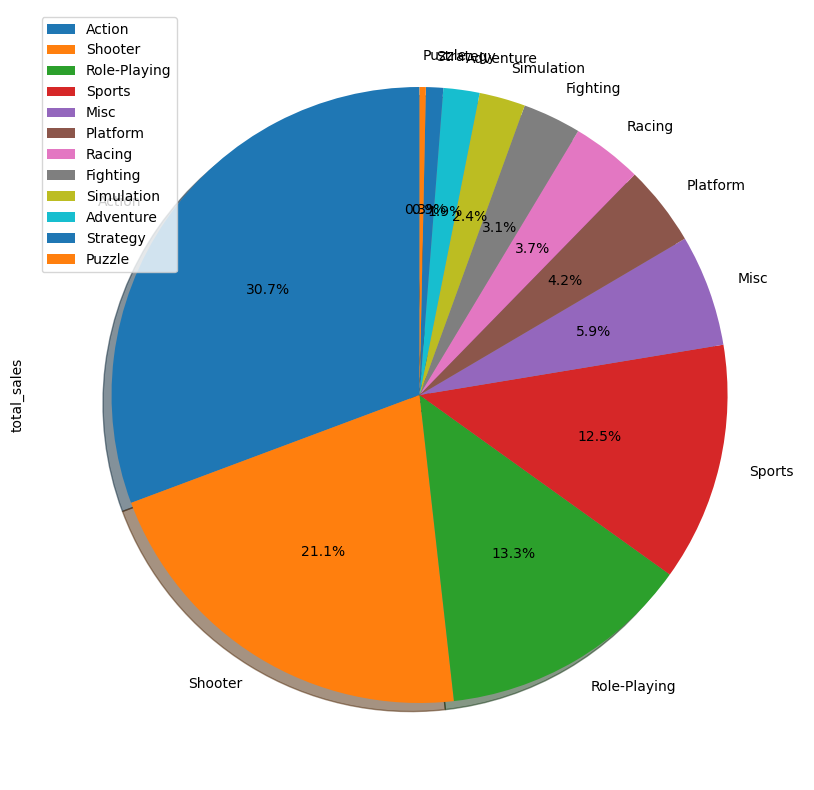

In [44]:
info_by_genre.sort_values(by='total_sales', ascending=False).plot(kind='pie', y='total_sales', figsize=(10,10), labels=info_by_genre.sort_values(by='total_sales', ascending=False)['genre'], autopct='%1.1f%%', startangle=90, shadow=True)


Построение графика по количеству игр

<AxesSubplot: ylabel='games_count'>

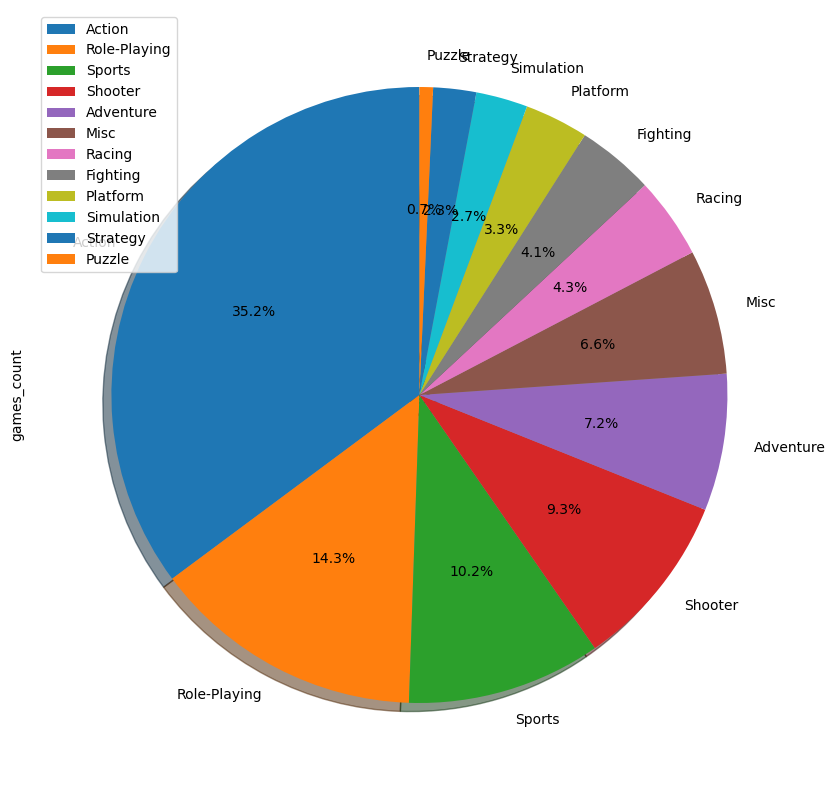

In [45]:
info_by_genre.sort_values(by='games_count', ascending=False).plot(kind='pie', y='games_count', figsize=(10,10), labels=info_by_genre.sort_values(by='games_count', ascending=False)['genre'], autopct='%1.1f%%', startangle=90, shadow=True)


ТОП 5 жанров игр:
* По продажам:
    * Action;
    * Shooter;
    * Role-Playing;
    * Sports;
    * Misc.
* По количеству:
    * Action;
    * Role-Playing;
    * Adventure;
    * Sports;
    * Shooter.<br>
    
Вывод:<br>
Так как мы видим отличия в списке топ 5 игр по количеству и продажам, то делаем вывод, не все игры одного конкретного жанра хорошо продаются.


<AxesSubplot: title={'center': 'Медианные продажи на каждом жанре'}, xlabel='genre', ylabel='total_sales'>

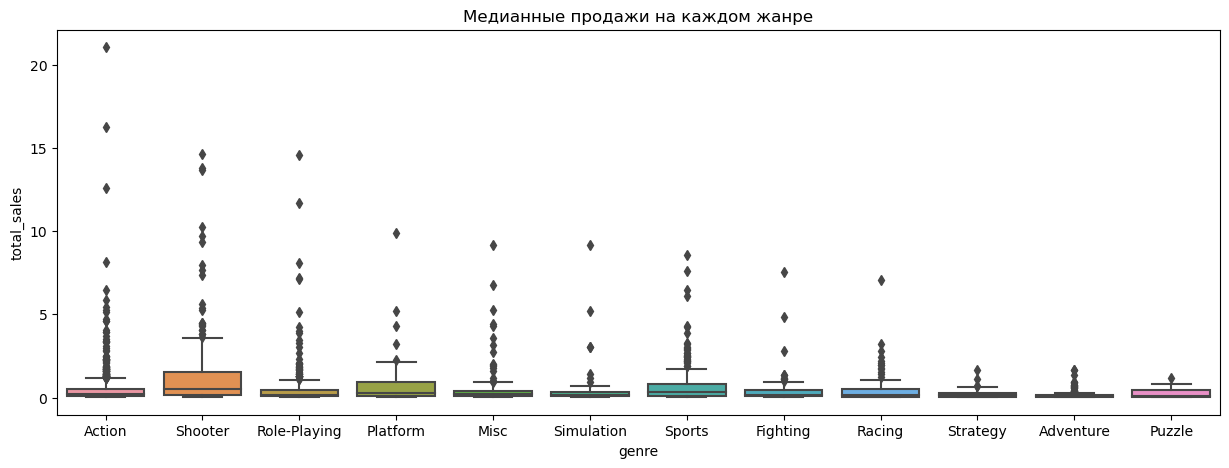

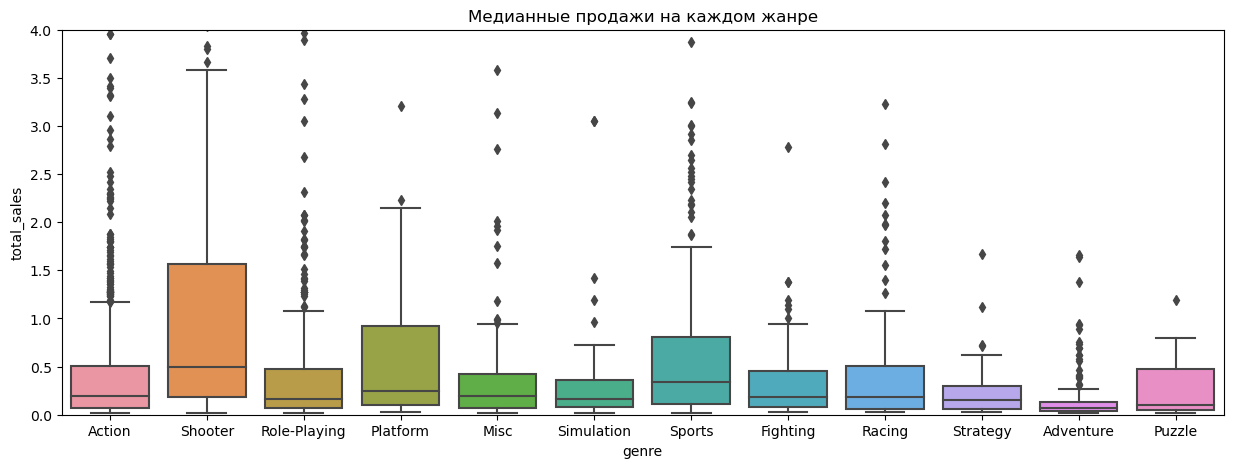

In [46]:
plt.figure(figsize=(15,5))
plt.title("Медианные продажи на каждом жанре")
sns.boxplot(data=actual_period, x="genre", y="total_sales")

plt.figure(figsize=(15,5))
plt.ylim(0, 4)
plt.title("Медианные продажи на каждом жанре")
sns.boxplot(data=actual_period, x="genre", y="total_sales")

Для удобства найдем медианы в числовом виде

In [47]:
pd.pivot_table(actual_period, values='total_sales', index=['genre'], aggfunc='median').sort_values(by='total_sales', ascending=False).reset_index()

,genre,total_sales
0,Shooter,0.495
1,Sports,0.340
2,Platform,0.250
3,Misc,0.190
4,Action,0.190
5,Fighting,0.180
6,Racing,0.180
7,Role-Playing,0.160
8,Simulation,0.160
9,Strategy,0.155


Вывод:
ТОП 5 жанров игр:
* По продажам:
    * Action;
    * Sports;
    * Shooter;
    * Role-Playing;
    * Platform.
* По количеству:
    * Action;
    * Sports;
    * Misc;
    * Role-Playing;
    * Shooter.<br>
    
Вывод:<br>
Так как мы видим отличия в списке топ 5 игр по количеству и продажам, то делаем вывод, не все игры одного конкретного жанра хорошо продаются.

Проанализировав медианные продажи приходим к следующим выводам:
* Лучше всего продаются игры в жанре Shooter;
* Далее жанр Sports;
* Далее жанр Platform;
* Далее жанр RP;
* Далее жанр Racing.

### Вывод

**Анализ количества игр выпущенных в разные годы:**<br>
* Количество выпускаемых игр до 1990 приблизительно на одном и том же уровне, что связано очевидно со слабой распространенностью компьютеров и приставок (кроме бума в 1981, обоснованным появлением первых устройств).<br>
* Далее видим сильное возрастания количества выпускаемых игр в год, что в первую очередь связано с тем, что устройства для игр стали становиться сильно доступнее для массового потребления.<br>
* С 2000 года по 2010 год мы видим стремительное увеличение выпускаемых игр в год, что обосновано появлением интернета и устройств позволяющих играть почти в каждом доме, а так же в связи с комерциализацией этой отрасли. В это время игры приносили очень большие доходы, в связи с чем их разрабатывалось очень много.<br>
* С 2010 года мы видим сворачивание выпуска игр, так как в предыдущие годы появилось слишком много компаний и частных разработчиков выпускающих большое количество не качественных игр ради заработка, инвесторы начали переходить от количества проектов к качеству, а так же из-за пресыщения рынка не качественными продуктами.

**Анализ изменения продаж по платформам:**<br>
* В среднем платформы набирают популярность около пяти лет, затем три четыре года популярность падает
* Медианное время жизни платформы: 8 лет

**Выборка данных за актуальный период:**
Актуальный период это перид с 2012 года по 2016 год, так как с 2012 года рынок перешел к новой логике потребления, о чем мной было описано в выводе пункта 3.1.

**Определение потенциально прибыльных платформ:**<br>
Так как мы анализируем точку отсчета за декабрь 2016 года рассматриваем результаты 2015 года:
* Лидируют по продажам:
    * PS4
    * XOne
    * 3DS
* Продажи растут:
    * PS4
    * XOne
* Продажи падают:
    * 3DS
    
**График «ящик с усами» по глобальным продажам игр в разбивке по платформам:**<br>
* Показатели продаж PS4 и XOne очень похожи, что в целом логично так как это конкурирующие платформы;
* Все остальные платформы имеют показатели продаж сильно ниже;

**Изучение влияния на продажи внутри одной популярной платформы отзывы пользователей и критиков:**<br>
Линейной корреляции между отзывами пользователей и критиков, и продажами не обнаружено.<br>
Тем не менее видим особенности:
* Критики систематично на всех платформах дают более высокие оценки более продаваемым играм:
    * Возможно это связано с тем, что критики более объективно относятся к играм;
    * Возможно с тем, что у более продаваемых игр больше бюджет на рекламу;
    * А может и с тем, что критики лучше чувствуют мейнстрим.
* У пользователей Xone и PS4 игра с хорошими продажами имеет большую вероятность получить хорошие оценки, чего не скажешь про платформу 3DS.

**Анализ распределения игр по жанрам:**<br>
Вывод:
ТОП 5 жанров игр:
* По продажам:
    * Action;
    * Sports;
    * Shooter;
    * Role-Playing;
    * Platform.
* По количеству:
    * Action;
    * Sports;
    * Misc;
    * Role-Playing;
    * Shooter.<br>
    
Проанализировав медианные продажи приходим к следующим выводам:
* Лучше всего продаются игры в жанре Shooter;
* Далее жанр Sports;
* Далее жанр Platform;
* Далее жанр RP;
* Далее жанр Racing.

##  Составьте портрет пользователя каждого региона

### Самые популярные платформы

Сборка сводной таблицы с продажами по регионам

In [48]:
region_list = ['na_sales', 'eu_sales', 'jp_sales']

region_sales_by_platform = pd.pivot_table(actual_period, values=region_list, index=['platform'], aggfunc='sum').reset_index()
region_sales_by_platform.head(2)

,platform,eu_sales,jp_sales,na_sales
0,3DS,42.66,87.37,55.39
1,DS,3.63,3.70,4.93


Вывод графиков для анализа (выводим топ 5 платформ)

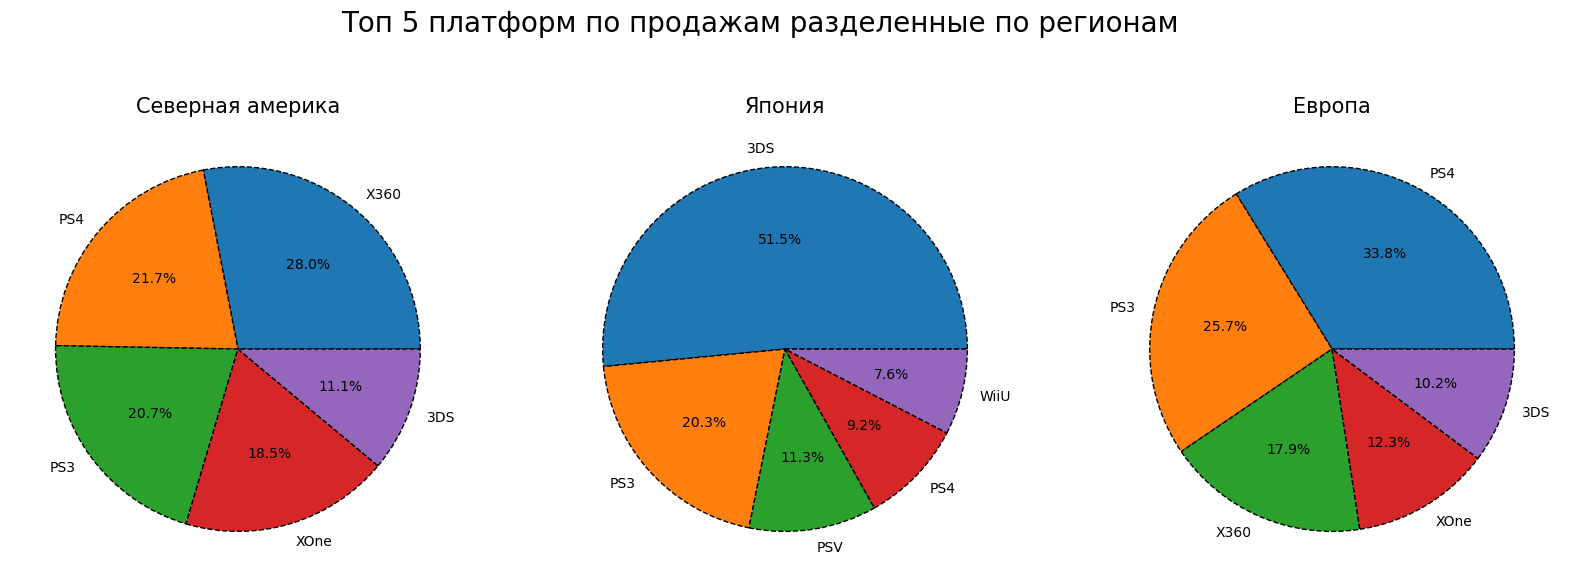

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,7))
ax1.pie(region_sales_by_platform['na_sales'].sort_values(ascending=False).head(5),
       labels=region_sales_by_platform.sort_values(by='na_sales', ascending=False)['platform'].head(5),
       autopct='%1.1f%%',
       wedgeprops={'lw':1, 'ls':'--', 'edgecolor': 'k'})
ax1.set_title('Северная америка', size=15)
ax2.pie(region_sales_by_platform['jp_sales'].sort_values(ascending=False).head(5),
       labels=region_sales_by_platform.sort_values(by='jp_sales', ascending=False)['platform'].head(5),
       autopct='%1.1f%%',
       wedgeprops={'lw':1, 'ls':'--', 'edgecolor': 'k'})
ax2.set_title('Япония', size=15)
ax3.pie(region_sales_by_platform['eu_sales'].sort_values(ascending=False).head(5),
       labels=region_sales_by_platform.sort_values(by='eu_sales', ascending=False)['platform'].head(5),
       autopct='%1.1f%%',
       wedgeprops={'lw':1, 'ls':'--', 'edgecolor': 'k'})
ax3.set_title('Европа', size=15)
fig.suptitle("Топ 5 платформ по продажам разделенные по регионам", fontsize=20)
plt.show()


Вывод:
Топ 5 платформ в Северной Америке:
* X360
* PS4
* PS3
* XOne
* 3DS

Топ 5 платформ в Японии:
* 3DS
* PS3
* PSV
* PS4
* WiiU

Топ 5 платформ в Европе:
* PS4
* PS3
* X360
* XOne
* 3DS

### Самые популярные жанры

Сборка сводной таблицы с продажами по регионам

In [50]:
region_list = ['na_sales', 'eu_sales', 'jp_sales']

region_sales_by_genre = pd.pivot_table(actual_period, values=region_list, index=['genre'], aggfunc='sum').reset_index()
region_sales_by_genre.head(2)

,genre,eu_sales,jp_sales,na_sales
0,Action,160.84,50.95,179.77
1,Adventure,9.20,6.55,8.81


Вывод графиков для анализа (выводим топ 15 жанров)

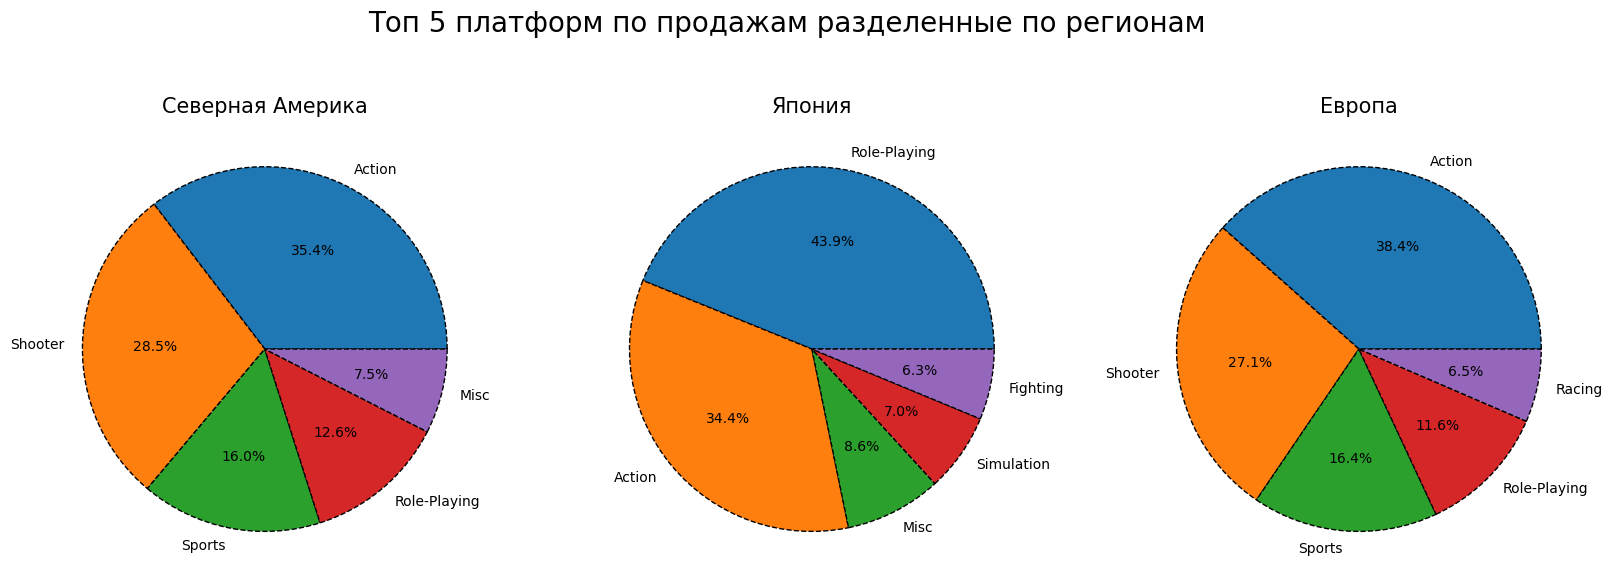

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,7))
ax1.pie(region_sales_by_genre['na_sales'].sort_values(ascending=False).head(5),
       labels=region_sales_by_genre.sort_values(by='na_sales', ascending=False)['genre'].head(5),
       autopct='%1.1f%%',
       wedgeprops={'lw':1, 'ls':'--', 'edgecolor': 'k'})
ax1.set_title('Северная Америка', size=15)
ax2.pie(region_sales_by_genre['jp_sales'].sort_values(ascending=False).head(5),
       labels=region_sales_by_genre.sort_values(by='jp_sales', ascending=False)['genre'].head(5),
       autopct='%1.1f%%',
       wedgeprops={'lw':1, 'ls':'--', 'edgecolor': 'k'})
ax2.set_title('Япония', size=15)
ax3.pie(region_sales_by_genre['eu_sales'].sort_values(ascending=False).head(5),
       labels=region_sales_by_genre.sort_values(by='eu_sales', ascending=False)['genre'].head(5),
       autopct='%1.1f%%',
       wedgeprops={'lw':1, 'ls':'--', 'edgecolor': 'k'})
ax3.set_title('Европа', size=15)
fig.suptitle("Топ 5 платформ по продажам разделенные по регионам", fontsize=20)
plt.show()

Вывод:
Топ 5 жанров в Северной Америке:
* Action
* Shooter
* Sports
* Role-Playing
* Misc

Топ 5 жанров в Японии:
* Role-Playing
* Action
* Misc
* Simulation
* Fighting


Топ 5 жанров в Европе:
* Action
* Shooter
* Sports
* Role-Playing
* Racing

Описание различий в долях продаж:
* Топ 4 жанров Европы и Америки сходятся;
* Аналогично как и с долями по платформам поведение пользователя Европы и америки похожи и в выборе жанров;
* В Японии видим ярко выраженное препочтение РПГ.

### Влияние рейтинга ESRB на продажи в отдельных регионах

Изучим дополнительно колонку рейтинга

In [52]:
print(actual_period['rating'].describe())

count     2394
unique       5
top         NR
freq       918
Name: rating, dtype: object


In [53]:
print('Количество не заполненных значений:', actual_period['rating'].isna().sum())

Количество не заполненных значений: 0


Выведем уникальные значения

In [54]:
actual_period['rating'].unique()

array(['M', 'NR', 'E', 'E10+', 'T'], dtype=object)

Вывод суммарных продаж по рейтингам

In [55]:
actual_period.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')


,eu_sales,jp_sales,na_sales
rating,,,
E,112.50,28.31,114.21
E10+,57.05,8.18,77.81
M,194.25,21.17,231.49
NR,90.60,104.47,103.10
T,52.64,25.86,65.80


Вывод:<br>
По суммарным продажам по рейтингам одинаковая картина по региону Европа и Северная америка:
* Больше всего продаж игр с рейтингом M;
* Далее продажи с рейтингом E;
* Далее продажи игр с рейтингом E10+;
* Меньше всего продаж игр с рейтингом T;
* Продаж игр с отсутствующим рейтингом около 20%.
    
По региону Япония:
* Больше всего продаж игр без рейтинга (около 60%);
* Далее идут одинаковые продажи игр с рейтингами Т, М, Е;
* Меньше всего продаж игр с рейтингом E10+.

<AxesSubplot: xlabel='rating', ylabel='jp_sales'>

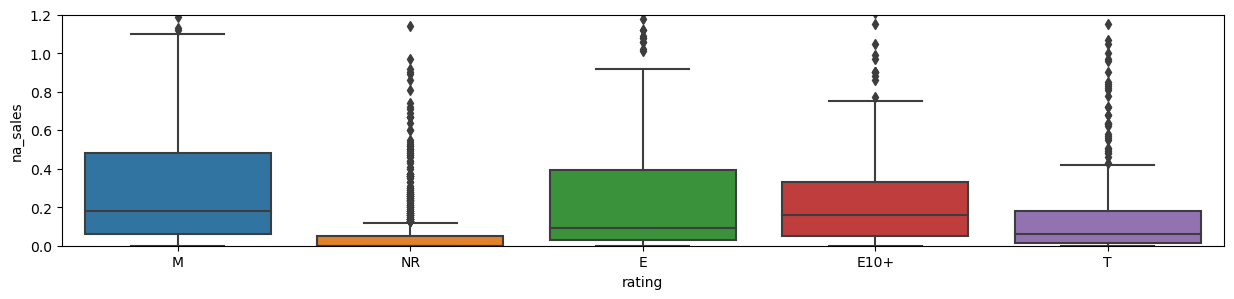

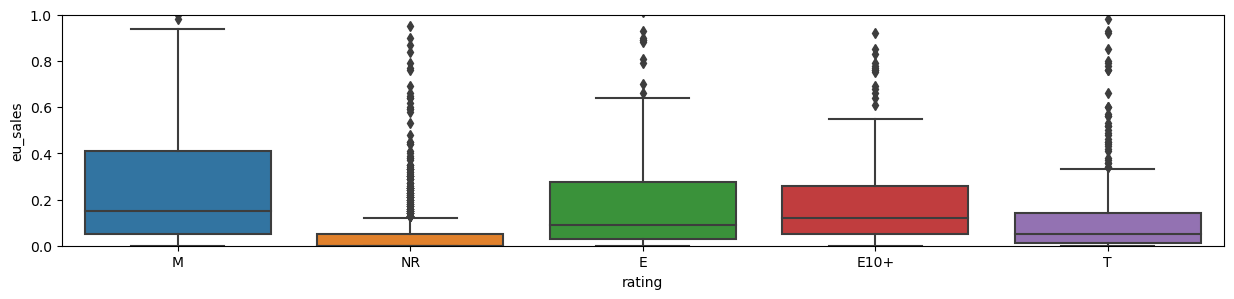

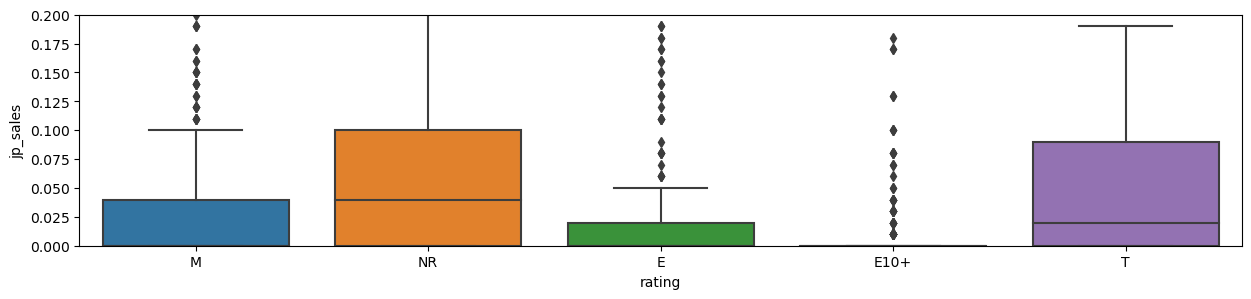

In [56]:
plt.figure(figsize=(15,3))
plt.ylim(0, 1.2)
sns.boxplot(data=actual_period, x="rating", y="na_sales")

plt.figure(figsize=(15,3))
plt.ylim(0, 1)
sns.boxplot(data=actual_period, x="rating", y="eu_sales")

plt.figure(figsize=(15,3))
plt.ylim(0, 0.2)
sns.boxplot(data=actual_period, x="rating", y="jp_sales")

In [57]:
region_list = ['na_sales', 'eu_sales', 'jp_sales']

region_sales_by_rating = pd.pivot_table(actual_period, values=region_list, index=['rating'], aggfunc='sum').reset_index()
region_sales_by_rating.head(2)

,rating,eu_sales,jp_sales,na_sales
0,E,112.50,28.31,114.21
1,E10+,57.05,8.18,77.81


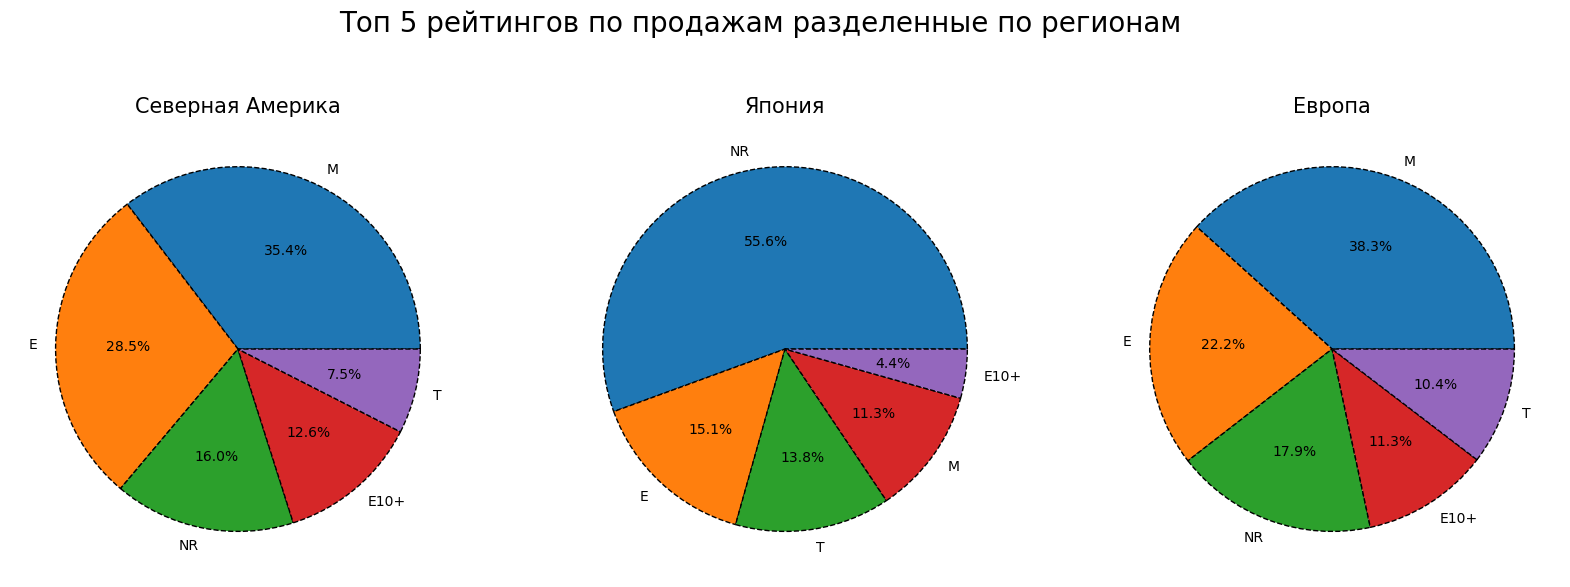

In [58]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,7))
ax1.pie(region_sales_by_genre['na_sales'].sort_values(ascending=False).head(5),
       labels=region_sales_by_rating.sort_values(by='na_sales', ascending=False)['rating'].head(5),
       autopct='%1.1f%%',
       wedgeprops={'lw':1, 'ls':'--', 'edgecolor': 'k'})
ax1.set_title('Северная Америка', size=15)
ax2.pie(region_sales_by_rating['jp_sales'].sort_values(ascending=False).head(5),
       labels=region_sales_by_rating.sort_values(by='jp_sales', ascending=False)['rating'].head(5),
       autopct='%1.1f%%',
       wedgeprops={'lw':1, 'ls':'--', 'edgecolor': 'k'})
ax2.set_title('Япония', size=15)
ax3.pie(region_sales_by_rating['eu_sales'].sort_values(ascending=False).head(5),
       labels=region_sales_by_rating.sort_values(by='eu_sales', ascending=False)['rating'].head(5),
       autopct='%1.1f%%',
       wedgeprops={'lw':1, 'ls':'--', 'edgecolor': 'k'})
ax3.set_title('Европа', size=15)
fig.suptitle("Топ 5 рейтингов по продажам разделенные по регионам", fontsize=20)
plt.show()

Вывод:<br>
Для региона Северной Америки и Европы мы видим почти одинаковое распределение продаж по рейтингам.<br>

Вывод:
По суммарным продажам по рейтингам одинаковая картина по региону Европа и Северная америка:
* Больше всего продаж игр с рейтингом M;
* Далее продажи с рейтингом E;
* Далее продажи игр с рейтингом E10+;
* Меньше всего продаж игр с рейтингом T;
* Продаж игр с отсутствующим рейтингом около 17%.

По региону Япония:
* Больше всего продаж игр без рейтинга (около 57%);
* Далее идут одинаковые продажи игр с рейтингами Т, М, Е;
* Меньше всего продаж игр с рейтингом E10+.

### Вывод

**Самые популярные платформы:**<br>
* Топ 5 платформ в Северной Америке:
    * X360
    * PS4
    * PS3
    * XOne
    * 3DS
* Топ 5 платформ в Японии:
    * 3DS
    * PS3
    * PSV
    * PS4
    * WiiU
* Топ 5 платформ в Европе:
    * PS4
    * PS3
    * X360
    * XOne
    * 3DS

**Самые популярные жанры:**<br>
* Топ 5 жанров в Северной Америке:
    * Action
    * Shooter
    * Sports
    * Role-Playing
    * Misc
* Топ 5 жанров в Японии:
    * Role-Playing
    * Action
    * Misc
    * Simulation
    * Fighting
* Топ 5 жанров в Европе:
    * Action
    * Shooter
    * Sports
    * Role-Playing
    * Racing
* Описание различий в долях продаж:
    * Топ 4 жанров Европы и Америки сходятся;
    * Аналогично как и с долями по платформам поведение пользователя Европы и америки похожи и в выборе жанров;
    * В Японии видим ярко выраженное препочтение РПГ.

**Влияние рейтинга ESRB на продажи в отдельных регионах:**<br>
Для региона Северной Америки и Европы мы видим почти одинаковое распределение продаж по рейтингам.<br>
По суммарным продажам по рейтингам одинаковая картина по региону Европа и Северная америка:
* Больше всего продаж игр с рейтингом M;
* Далее продажи с рейтингом E;
* Далее продажи игр с рейтингом E10+;
* Меньше всего продаж игр с рейтингом T;
* Продаж игр с отсутствующим рейтингом около 17%.

По региону Япония:
* Больше всего продаж игр без рейтинга (около 57%);
* Далее идут одинаковые продажи игр с рейтингами Т, М, Е;
* Меньше всего продаж игр с рейтингом E10+.

## Проверка гипотез

### Проверка гипотезы средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Гипотеза H0: среднее генеральной совокупности пользовательских рейтингов платформы Xbox One равно среднему генеральной совокупности пользовательских рейтингов платформы PC.<br>
Исходя из гипотезы H0 формируем гипотезу Н1.<br>
Гипотеза H1: среднее генеральной совокупности пользовательских рейтингов платформы Xbox One не равно среднему генеральной совокупности пользовательских рейтингов платформы PC.

In [59]:
from scipy import stats as st
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(
    actual_period.query("user_score.notna() and platform == 'PC'", engine='python')['user_score'], 
    actual_period.query("user_score.notna() and platform == 'XOne'", engine='python')['user_score'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.7343578635817871
Не получилось отвергнуть нулевую гипотезу


Принимать решение о принятии или отвержении нулевой гипотезы будем по p-value. Это вероятность получить наблюдаемый результат при условии, что нулевая гипотеза верна.<br>
Полученное значение p-value говорит о том, что вероятность получить такое или большее различие случайно около 62%. Это слишком большая вероятность, чтобы делать вывод о значимом различии между средним пользовательских рейтингов жанра Action и Sports.<br>
Разница между значениями достаточно мала, то есть вероятность её получить случайно велика 62%. 

### Проверка гипотезы средние пользовательские рейтинги жанров Action и Sports разные

Гипотеза H0: среднее генеральной совокупности пользовательских рейтингов жанра Action равно среднему генеральной совокупности пользовательских рейтингов жанра Sports.<br>
Исходя из гипотезы H0 формируем гипотезу Н1.<br>
Гипотеза H1: среднее генеральной совокупности пользовательских рейтингов жанра Action не равно среднему генеральной совокупности пользовательских рейтингов жанра Sports.<br>

In [60]:
from scipy import stats as st
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(
    actual_period.query("user_score.notna() and genre == 'Action'", engine='python')['user_score'], 
    actual_period.query("user_score.notna() and genre == 'Sports'", engine='python')['user_score'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 2.820043306561671e-26
Отвергаем нулевую гипотезу


Принимать решение о принятии или отвержении нулевой гипотезы будем по p-value. Это вероятность получить наблюдаемый результат при условии, что нулевая гипотеза верна.<br>
Полученное значение p-value говорит о том, что вероятность получить такое или большее различие случайно около 0%. Это слишком малая вероятность, чтобы сделать вывод в пользу теории H0.<br>
Разница между значениями достаточно велика, то есть вероятность её получить случайно слишком низка около 0%.

### Вывод

**Проверка гипотезы средние пользовательские рейтинги платформ Xbox One и PC одинаковые**
- Сформулирована гипотеза H0 и H1:
    - Гипотеза H0: среднее генеральной совокупности пользовательских рейтингов платформы Xbox One равно среднему генеральной совокупности пользовательских рейтингов платформы PC.<br>
- Исходя из гипотезы H0 сформирована гипотеза Н1.<br>
    - Гипотеза H1: среднее генеральной совокупности пользовательских рейтингов платформы Xbox One не равно среднему генеральной совокупности пользовательских рейтингов платформы PC.

Гипотезу H0 не отвергаем по критерию p-value.<br>
Разница между значениями достаточно мала, то есть вероятность её получить случайно велика 62%.<br>

**Проверка гипотезы средние пользовательские рейтинги жанров Action и Sports разные.**
- Сформулирована гипотеза H0 и H1:
    - Гипотеза H0: среднее генеральной совокупности пользовательских рейтингов жанра Action равно среднему генеральной совокупности пользовательских рейтингов жанра Sports.<br>
- Исходя из гипотезы H0 сформирована гипотеза Н1.<br>
    - Гипотеза H1: среднее генеральной совокупности пользовательских рейтингов жанра Action не равно среднему генеральной совокупности пользовательских рейтингов жанра Sports.

Гипотезу H0 отвергаем по критерию p-value.<br>
Разница между значениями достаточно велика, то есть вероятность её получить случайно слишком низка около 0%. 

## Общий вывод

<font size = 4>**Пункт 1. Загрузка данных и изучение общей информации**</font><br>
    Загружены данные для проведения анализа и необходимые библиотеки<br>
    <br>
<font size = 4>**Пункт 2. Подготовка датафрейма games**</font><br>
* Колонка name;
    * Удалены две строки с пустыми значениями;
* Колонка year_of_release;
    * Заполнены отсутствующие значения колонки значениями этой же колонки, найденной по колонке name;
    * Отсутствие данных колонки критично, то есть строки с отсутствующими значениями мы анализировать не можем. Мы их удаляем, подразумевая то, что таких строк очень мало и на ход анализа удаление этого количества не повлияет;
    * Переводим колонку из float64 в int64 для удобство обработки;
* Добавление колонки total_sales на основе суммы колонок na_sales, eu_sales, jp_sales, other_sales;
* Колонки critic_score, user_score;
    * Количество не заполненых колонок очень велико, однако для их замены нет корректного метода, оставляем как есть;
    * Переводим колонку critic_score и user_score из float64 в int64 для удобство обработки;
    * Значение tbd обозначает "to be determinated", то есть неизвестно, заменяем на nan;
* Колонка rating;
    * Все пустые значения заменены на 'NR', для выделения области игр без рейтинга;
    * Заменено значение RP на 'NR', так как RP это обозначение ожидание рейтинга, а не рейтинг;
    * Заменено значение K-A на E, так как K-A ранее использовалось как Е.
    
<font size = 4>**Пункт 3. Исследовательский анализ данных**</font><br>
**Анализ количества игр выпущенных в разные годы:**<br>
* Количество выпускаемых игр до 1990 приблизительно на одном и том же уровне, что связано очевидно со слабой распространенностью компьютеров и приставок (кроме бума в 1981, обоснованным появлением первых устройств).<br>
* Далее видим сильное возрастания количества выпускаемых игр в год, что в первую очередь связано с тем, что устройства для игр стали становиться сильно доступнее для массового потребления.<br>
* С 2000 года по 2010 год мы видим стремительное увеличение выпускаемых игр в год, что обосновано появлением интернета и устройств позволяющих играть почти в каждом доме, а так же в связи с комерциализацией этой отрасли. В это время игры приносили очень большие доходы, в связи с чем их разрабатывалось очень много.<br>
* С 2010 года мы видим сворачивание выпуска игр, так как в предыдущие годы появилось слишком много компаний и частных разработчиков выпускающих большое количество не качественных игр ради заработка, инвесторы начали переходить от количества проектов к качеству, а так же из-за пресыщения рынка не качественными продуктами.

**Анализ изменения продаж по платформам:**<br>
* В среднем платформы набирают популярность около пяти лет, затем три четыре года популярность падает
* Медианное время жизни платформы: 8 лет

**Выборка данных за актуальный период:**
Актуальный период это перид с 2012 года по 2016 год, так как с 2012 года рынок перешел к новой логике потребления, что было описано в выводе пункта 3.1.

**Определение потенциально прибыльных платформ:**<br>
Так как мы анализируем точку отсчета за декабрь 2016 года рассматриваем результаты 2015 года:
* Лидируют по продажам:
    * PS4
    * XOne
    * 3DS
* Продажи растут:
    * PS4
    * XOne
* Продажи падают:
    * 3DS
    
Вывод: потенциально прибыльные платформы это PS4, XOne.
    
**График «ящик с усами» по глобальным продажам игр в разбивке по платформам:**<br>
* Показатели продаж PS4 и XOne очень похожи, что в целом логично так как это конкурирующие платформы;
* Все остальные платформы имеют показатели продаж сильно ниже;

**Изучение влияния на продажи внутри одной популярной платформы отзывы пользователей и критиков:**<br>
Линейной корреляции между отзывами пользователей и критиков, и продажами не обнаружено.<br>
Тем не менее видим особенности:
* Критики систематично на всех платформах дают более высокие оценки более продаваемым играм:
    * Возможно это связано с тем, что критики более объективно относятся к играм;
    * Возможно с тем, что у более продаваемых игр больше бюджет на рекламу;
    * А может и с тем, что критики лучше чувствуют мейнстрим.
* У пользователей Xone и PS4 игра с хорошими продажами имеет большую вероятность получить хорошие оценки, чего не скажешь про платформу 3DS.
    
**Анализ распределения игр по жанрам:**<br>
Вывод:
ТОП 5 жанров игр:
* По продажам:
    * Action;
    * Sports;
    * Shooter;
    * Role-Playing;
    * Platform.
* По количеству:
    * Action;
    * Sports;
    * Misc;
    * Role-Playing;
    * Shooter.<br>
    
Проанализировав медианные продажи приходим к следующим выводам:
* Лучше всего продаются игры в жанре Shooter;
* Далее жанр Sports;
* Далее жанр Platform;
* Далее жанр RP;
* Далее жанр Racing.

<font size = 4>**Пункт 4. Составление портрета пользователя каждого региона**</font><br>
**Самые популярные платформы:**<br>
* Топ 5 платформ в Северной Америке:
    * X360
    * PS4
    * PS3
    * XOne
    * 3DS
* Топ 5 платформ в Японии:
    * 3DS
    * PS3
    * PSV
    * PS4
    * WiiU
* Топ 5 платформ в Европе:
    * PS4
    * PS3
    * X360
    * XOne
    * 3DS

**Самые популярные жанры:**<br>
* Топ 5 жанров в Северной Америке:
    * Action
    * Shooter
    * Sports
    * Role-Playing
    * Misc
* Топ 5 жанров в Японии:
    * Role-Playing
    * Action
    * Misc
    * Simulation
    * Fighting
* Топ 5 жанров в Европе:
    * Action
    * Shooter
    * Sports
    * Role-Playing
    * Racing
* Описание различий в долях продаж:
    * Топ 4 жанров Европы и Америки сходятся;
    * Аналогично как и с долями по платформам поведение пользователя Европы и америки похожи и в выборе жанров;
    * В Японии видим ярко выраженное препочтение РПГ.

**Влияние рейтинга ESRB на продажи в отдельных регионах:**<br>
Для региона Северной Америки и Европы мы видим почти одинаковое распределение продаж по рейтингам.<br>
По суммарным продажам по рейтингам одинаковая картина по региону Европа и Северная америка:
* Больше всего продаж игр с рейтингом M;
* Далее продажи с рейтингом E;
* Далее продажи игр с рейтингом E10+;
* Меньше всего продаж игр с рейтингом T;
* Продаж игр с отсутствующим рейтингом около 17%.

По региону Япония:
* Больше всего продаж игр без рейтинга (около 57%);
* Далее идут одинаковые продажи игр с рейтингами Т, М, Е;
* Меньше всего продаж игр с рейтингом E10+.

<font size = 4>**Пункт 5. Проверка гипотез**</font><br>
**Проверка гипотезы средние пользовательские рейтинги платформ Xbox One и PC одинаковые**
- Сформулирована гипотеза H0 и H1:
    - Гипотеза H0: среднее генеральной совокупности пользовательских рейтингов платформы Xbox One равно среднему генеральной совокупности пользовательских рейтингов платформы PC.<br>
- Исходя из гипотезы H0 сформирована гипотеза Н1.<br>
    - Гипотеза H1: среднее генеральной совокупности пользовательских рейтингов платформы Xbox One не равно среднему генеральной совокупности пользовательских рейтингов платформы PC.

Гипотезу H0 не отвергаем по критерию p-value.<br>
Разница между значениями достаточно мала, то есть вероятность её получить случайно велика 62%.<br>

**Проверка гипотезы средние пользовательские рейтинги жанров Action и Sports разные.**
- Сформулирована гипотеза H0 и H1:
    - Гипотеза H0: среднее генеральной совокупности пользовательских рейтингов жанра Action равно среднему генеральной совокупности пользовательских рейтингов жанра Sports.<br>
- Исходя из гипотезы H0 сформирована гипотеза Н1.<br>
    - Гипотеза H1: среднее генеральной совокупности пользовательских рейтингов жанра Action не равно среднему генеральной совокупности пользовательских рейтингов жанра Sports.

Гипотезу H0 отвергаем по критерию p-value.<br>
Разница между значениями достаточно велика, то есть вероятность её получить случайно слишком низка около 0%. 